## Pulse Parameterization

### Amplitude Function

In many qubit models the optimization parameters (or pulse parameters) do not appear as linear terms in the control Hamiltonian that must be given in the form

\begin{align}
H_c(t) = \sum_n u_n(t) B_n
\end{align}

where $u_n(t)$ are the control amplitudes and $B_n$ the control operators. Let's now assume that we want to parameterize our pulse with a set of parameters $v_n(t)$ that our control amplitudes depend on $u_n(t) = u_n(v_1(t), \dots , v_n(t))$.

This is given for our example of a qubit under Rabi-driving. The single pulse enters the Hamiltonian as:

\begin{equation}
H = \frac{ \omega_0}{2} \sigma_z +  A \text{sin}(\omega t + \delta)
\sigma_x,
\end{equation}

where $\omega_0$ is the resonance frequency, $A(t) = v_1(t)$ the driving amplitude and
$\delta=v_2(t)$ the phase shift of the driving signal.
We transform the Hamiltonian into the rotating frame to yield:

\begin{equation}
H = \frac{ A}{2} \text{cos} (\delta ) \sigma_x
+ \frac{ A}{2} \text{sin} (\delta ) \sigma_y.
\end{equation}

Now we identify the control amplitudes $u_1(t) = \frac{ A}{2} \text{cos} (\delta )$ and $u_2(t) = \frac{ A}{2} \text{sin}$. We can use the class
`AmplitudeFunction` to implement the relation between the optimization/ pulse parameters and the control amplitudes.


In [1]:
import numpy as np
from qopt import *

n_time_steps = 10
n_opt_pars = 2
n_ctrl_amps = 2

def amp_func(opt_pars):
    ctrl_amps = np.empty((opt_pars.shape[0], n_ctrl_amps))
    ctrl_amps[:, 0] = .5 * opt_pars[:, 0] * np.cos(opt_pars[:, 1])
    ctrl_amps[:, 1] = .5 * opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    return ctrl_amps

def deriv_amp_func(opt_pars):
    ctrl_amps_deriv = np.empty((opt_pars.shape[0], n_opt_pars, n_ctrl_amps))

    ctrl_amps_deriv[:, 0, 0] = .5 * np.cos(opt_pars[:, 1])
    ctrl_amps_deriv[:, 0, 1] = .5 * np.sin(opt_pars[:, 1])

    ctrl_amps_deriv[:, 1, 0] = -.5 * opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    ctrl_amps_deriv[:, 1, 1] = .5 * opt_pars[:, 0] * np.cos(opt_pars[:, 1])

    return ctrl_amps_deriv

amplitude_function = CustomAmpFunc(
    value_function=amp_func,
    derivative_function=deriv_amp_func
)

We also need to implement the derivative to use the model in a gradient based optimization algorithm with analytic derivatives. If only a simulation is required, then the derivative can be set to `derivative_function=None`.

### Combination with Transfer Functions

The amplitude function can also be combined in a solver with transfer functions. According to the qopt structure the transfer function is always executed before the amplitude function and thus qopt distinguishes the following parameters.

1. **Optimization Parameters**: If no optimization is applied, they are also referred to as *pulse parameters*. These are the most basic parameters that define the actual control pulse.
2. **Transferred Parameters**: The application of the transfer function to the optimization parameters yields the transferred parameters. The number of optimization parameters is identical to the number of transferred parameters but the timescale might change.
3. **Control Amplitudes**: The application of the amplitude function to the transferred parameters yields the control amplitudes. These operate on the same time steps as the transferred parameters, but the number of control amplitudes can be different from the number of transferred parameters.

When in doubt obout the correct dimensions of a simulation, it is important to keep this structure in mind an consider which function operates on which quantity.


![qopt structure](..\static\QoptStructure.png)

For the transfer function we use a gaussian convolution:

In [2]:
oversampling_tf = OversamplingTF(
    oversampling=10,
    num_ctrls=2
)
gaussian_tf = GaussianConvolution(
    sigma=2,
    num_ctrls=2
)
combined_tf = ConcatenateTF(
    tf1=oversampling_tf,
    tf2=gaussian_tf
)

For the optimization we can give the transfer and amplitude function as
attributes to the solver class.

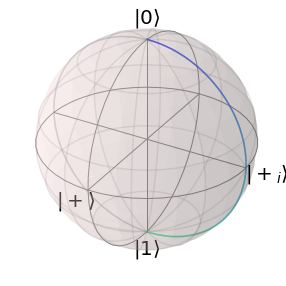

In [3]:
from qopt.matrix import DenseOperator
from qopt.solver_algorithms import SchroedingerSolver
from qopt.cost_functions import OperationInfidelity


sigma_x = DenseOperator(np.asarray([[0, 1], [1, 0]]))
sigma_y = DenseOperator(np.asarray([[0, -1j], [1j, 0]]))
sigma_z = DenseOperator(np.asarray([[1, 0], [0, -1]]))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=.1 * np.ones(n_time_steps),
    transfer_function=combined_tf,
    amplitude_function=amplitude_function
)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x.exp(np.pi * .5j)
)

from qopt.simulator import Simulator

simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[entanglement_infidelity, ]
)

from qopt.optimize import LeastSquaresOptimizer

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 1000,
    "min_amplitude_change": 1e-8
}

upper_bounds = 2 * 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)
np.random.seed(0)
random_pulse = np.random.rand(n_time_steps, n_opt_pars)
result = optimizer.run_optimization(initial_control_amplitudes=random_pulse)
solver.plot_bloch_sphere(result.final_parameters)


By using the amplitude and the transfer function, the simulation becomes increasingly complex and more prone to errors. We recommend to debug qopt simulations step by step and provide convenience functions to do so. Errors in the transfer function usually provide a different behavior and can be found using the plot function. Errors in the implementation of the amplitude function are usually of numeric nature and can be found by comparing the analytic derivatives to numeric derivatives calculated by finite differences using the convenience function:


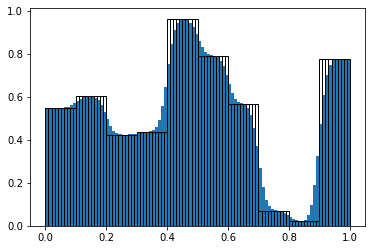

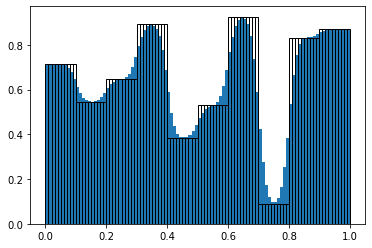

(5.585198532671447e-08, 4.079100349882343e-06)

In [4]:
solver.transfer_function.plot_pulse(random_pulse)
simulator.compare_numeric_to_analytic_gradient(random_pulse)